### Project Overview

This project utilizes Yellow Cab data, provided by the  NYC Taxi and Limousine Commission, to predict three different parameters:

1. Total  Fare prediction - Fare + Tips 
2. Elapsed time (ride duration) prediction 
3. "Trip combination" traffic volume 

The data can be found at https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page, with the Yellow Cab data dictionary available at https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf.



Editor: Joseph Cheung
The following code prepares the model for daily hourly traffic volume prediction.

The source data is based on the March 2022 data and for high volume (i.e. > 8000 trips on March) travelling locations (i.e. Pickup and Drop off location codes)    

In [ ]:
# Import packages
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

Trip_threshold = 8000
training_ratio = 0.7
testing_ratio = 1 - training_ratio
num_of_days=31
month='March'

%matplotlib inline

In [ ]:

'''
spark = SparkSession.builder \
                    .master('spark://qs2:7077') \
                    .appName("Group12_Yellow_TripApp_hourly") \
                    .config("spark.executor.memory", "50g") \
                    .config("spark.executor.cores", "44") \
                    .getOrCreate()
'''
sc = SparkContext('local')
spark = SparkSession(sc)

23/03/26 18:23:40 WARN Utils: Your hostname, qs2 resolves to a loopback address: 127.0.1.1; using 172.18.188.136 instead (on interface eno1)
23/03/26 18:23:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/26 18:23:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Read data
file = "yellow_tripdata_2022-03.parquet"
df = spark.read.parquet(file, header = True, inferSchema = True)


23/03/26 18:23:59 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


In [ ]:
# Create a view or table
 
temp_table_name = "yellow_trip"
 
df.createOrReplaceTempView(temp_table_name)


#### Inherited code to prepare the data from the Exploratory Data Analysis

In [ ]:
# Print df schema
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [ ]:
# Find dimensions of data
original_length = df.count()
print("Dimensions of original dataframe is:")
print(original_length, len(df.columns))

Dimensions of original dataframe is:
3627882 19


In [ ]:
# Drop missing values from dataframe
df = df.na.drop()

In [ ]:
# Drop  duplicates from dataframe
df = df.dropDuplicates()

In [ ]:
# Find dimensions of data after dropping missing values and duplicates
cleaned_length = df.count()
print("Dimensions of dataframe is now:")
print(cleaned_length, len(df.columns))

Dimensions of dataframe is now:
3510068 19


In [ ]:
# Remaining data in the dataframe
remaining_data_perc = cleaned_length/original_length*100
print("We have retained "+str(remaining_data_perc)+" of the data after eliminating null values and duplicates.")

We have retained 96.75254046300293 of the data after eliminating null values and duplicates.


#### Feature Engineering

In [ ]:
# Create new feature reflecting elapsed trip times (in seconds)
df = df.withColumn("elapsed_time", (df["tpep_dropoff_datetime"].cast("long")-df["tpep_pickup_datetime"].cast("long")))

# Create column indicating the day of week of the pickup
df = df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

# Create column indicating the day of week of the pickup
df = df.withColumn("day_of_month", F.dayofmonth("tpep_pickup_datetime"))

# Create column indicating the hour of the pickup
df = df.withColumn("hour", F.hour("tpep_pickup_datetime"))

# Filter out any rows where tpep_dropoff_datetime is less than tpep_pickup_datetime and trips are < 3 hrs (10,800 seconds)
df = df.where((df.tpep_dropoff_datetime > df.tpep_pickup_datetime) & (df.elapsed_time < 10800))

In [ ]:
# Columns to drop from PySpark dataframe and pandas dataframe
# Drop Store_and_fwd_flag: only provides information as to type of memory to store the trip data (in vehicle or server)
# Drop all fare/cost data other than total_amount to avoid information leakeage as this data is not known prior to the trip
# Drop tpep_dropoff_datetime as we have pickup time and elapsed time
drop_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag", "payment_type", "fare_amount", "extra",
             "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"]

# Drop dropCols from PySpark dataframe
df = df.drop(*drop_cols)

In [ ]:
# Create new column trip combining tuple combinations of PULocationID and DOLocationID
df = df.withColumn("trip", F.concat(F.col("PULocationID"), F.lit("_"), F.col("DOLocationID")))

# Fore One-Hot_Encoding we will need to reduce the number of trip categories to manage the size of the dataframe
# Filter dataframe for trip frequencies > threshold
trip_freq_threshold = Trip_threshold
mask = df.groupBy("trip").count().where(F.col("count") > trip_freq_threshold)
print("Number of trips > " +str(trip_freq_threshold)+ " is: " + str(mask.count()))
filtered_trips = [data[0] for data in mask.select('trip').collect()]

# Filter df for values only in filtered_trips list
df = df.where(df.trip.isin(filtered_trips))

Number of trips > 8000 is: 13


In [ ]:
df.columns

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'total_amount',
 'elapsed_time',
 'day_of_week',
 'day_of_month',
 'hour',
 'trip']

In [ ]:
df.groupby('trip').count().orderBy('count', ascending=False).show(5)

+-------+-----+
|   trip|count|
+-------+-----+
|237_236|22991|
|264_264|19122|
|236_237|19102|
|237_237|15411|
|236_236|15208|
+-------+-----+
only showing top 5 rows



In [ ]:
# Find dimensions of data after filtering elapsed times and trip frequencies
print("Dimensions of dataframe is now:")
print(df.count(), len(df.columns), len(df.select('trip').distinct().collect()))

Dimensions of dataframe is now:


164183 12 13


### Do the traffic volume prediction now

#### Do additional feature engineering
1. Make 3 time zone for the daily hour: 0 - 5, 6 - 17, 18 to 23  (see the clustering section) reason
2. Also do Weekend vs, Weekday (tested but not documented - test results show no effect)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def map_dict(dictionary):
  return udf(lambda col: dictionary.get(col), StringType())

a=np.arange(24)
HrZone = { x : 'Morning' for x in a[:6]}
HrZone.update({x : 'MidDay' for x in a[6:18]})
HrZone.update({x : 'Evening' for x in a[18:]})

df = df.withColumn("HrZone", map_dict(HrZone)("hour"))

a=np.arange(7)
a = a + 1
A = ['Weekday' if j < 6 else 'WeekEnd' for j in a]
w=dict(zip(a, A))

df = df.withColumn("WeekDayZone", map_dict(w)("day_of_week"))
df.show(3)

+--------+---------------+-------------+----------+------------+------------+------------+------------+-----------+------------+----+-------+-------+-----------+
|VendorID|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|total_amount|elapsed_time|day_of_week|day_of_month|hour|   trip| HrZone|WeekDayZone|
+--------+---------------+-------------+----------+------------+------------+------------+------------+-----------+------------+----+-------+-------+-----------+
|       2|            1.0|         1.72|       1.0|         141|         236|       14.69|         416|          3|           1|   0|141_236|Morning|    Weekday|
|       2|            1.0|         0.83|       1.0|         237|         161|       12.74|         435|          3|           1|   2|237_161|Morning|    Weekday|
|       1|            1.0|          2.4|       1.0|         236|         161|       15.36|         588|          3|           1|   2|236_161|Morning|    Weekday|
+--------+---------------+--

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
def plot_regression(df, target, prediction, title):

    df['resd']=np.round(df[prediction] - df[target], 4)
    df = df.sort_values(target, ascending=True)

    y_test=df[target]
    y_residual=df['resd']
    y_pred = df[prediction]

    fig, ax = plt.subplots(figsize=(7,5))
    scatter = ax.scatter(x=y_test, y=y_pred, c=y_residual, cmap="RdYlGn", marker="o", alpha=0.5, label='Predicted')
    cbar = plt.colorbar(scatter)
    cbar.ax.set_ylabel("Residual", rotation=90, fontsize=12)

    ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], "g--", alpha=0.75, linewidth=3, label='True')
    ax.set_xlabel("Actual", fontsize=12); 
    ax.set_ylabel("Predicted", fontsize=12); 
    ax.legend(loc='best')
    R_squared = r2_score(y_test, y_pred) 

    ax.set_title(title, fontsize=14)
    #additional text at the corner 
    plt.figtext(0.4,0.82,"$R^{2}$ = "+str(np.round(R_squared, 3)), fontsize=12, horizontalalignment="center",backgroundcolor=(0,0,0,0.4),color="w")


In [ ]:
df_2022=df

In [ ]:
df_training, df_testing = df_2022.randomSplit([training_ratio, testing_ratio], 24)

In [ ]:
print(len(df_training.select('trip').distinct().collect()), len(df_testing.select('trip').distinct().collect()))


13 13


In [ ]:
print(df_training.count(), df_testing.count())

115023 49160


In [ ]:
from pyspark.sql import Window

def col_mean_scaling(df, cols_to_scale):
    w = Window.partitionBy(F.lit(1))
    for col in cols_to_scale:
        df = df.withColumn(f"{col}", F.round(F.col(col) / F.avg(col).over(w), 2))
    return df



#### Prepare the data to perform the clustering 

In [ ]:
df_clustering=df_training.groupby('trip').pivot('hour').agg(F.count('trip')).orderBy('trip', ascending=False).fillna(0)


In [ ]:
# get column names that need to be normalized
cols = [col for col in df_clustering.columns if col != 'trip']

# sum the columns by row
rowmean = sum([df_clustering[x] for x in cols])/24

df_clustering2=df_clustering.select('trip', *((df_clustering[x] / rowmean).alias(x) for x in cols))

In [ ]:
df_clustering2.orderBy('trip', ascending=True).select('trip', '0').show(5)


23/03/26 18:25:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+
|   trip|                   0|
+-------+--------------------+
|141_236|0.020332090816672314|
|142_239|  0.0194331983805668|
|161_236|0.007609384908053...|
|161_237|0.006986899563318...|
|236_161|   0.028479403288693|
+-------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
%%time
VecAssembler = VectorAssembler().setInputCols(df_clustering2.columns[1:]).setOutputCol("features")
evaluator = ClusteringEvaluator()

MaxK=8
MaxR=MaxK-2
Ks= np.arange(2,MaxK,1)
Inertias = np.zeros(MaxR).astype(float)
sil_scores = np.zeros(MaxR).astype(float)
for k in Ks:
    print(k)
    kmeansModel = BisectingKMeans().setK(k).setFeaturesCol("features").setPredictionCol("prediction") 
    df_i1=VecAssembler.transform(df_clustering2)
    t_m1=kmeansModel.fit(df_i1)
    c_centers=t_m1.clusterCenters()

    predictionResult = t_m1.transform(df_i1)
    sil_scores[k-2]=evaluator.evaluate(predictionResult)
sil_scores


2


3


4


5


6


7


CPU times: user 336 ms, sys: 67.8 ms, total: 404 ms
Wall time: 2min 19s


array([0.40277176, 0.56277341, 0.40597198, 0.26434864, 0.44401725,
       0.34564891])

In [ ]:
k = sil_scores.argmax(axis=0)+2
print(k)

3


In [ ]:
%%time
kmeansModel = BisectingKMeans().setK(k).setFeaturesCol("features").setPredictionCol("prediction") 
df_i1=VecAssembler.transform(df_clustering2)
t_m1=kmeansModel.fit(df_i1)
c_centers=t_m1.clusterCenters()

predictionResult = t_m1.transform(df_i1)
predictionResult.groupby('prediction').count().orderBy('prediction', ascending=True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|    6|
|         1|    2|
|         2|    5|
+----------+-----+

CPU times: user 45.2 ms, sys: 13.9 ms, total: 59.1 ms
Wall time: 16.1 s


[Text(0.5, 1.0, 'Centroid Curves')]

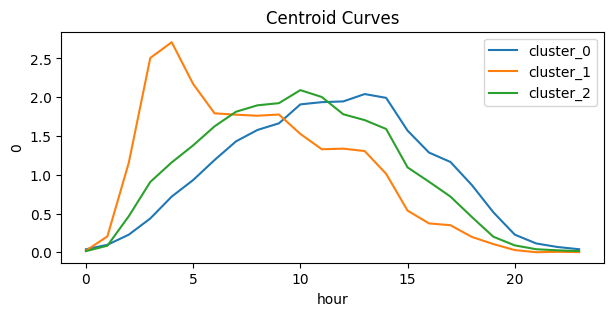

In [ ]:
import pandas as pd
labels=['cluster_'+str(x)  for x in range(len(c_centers))]
data={str(x) : c_centers[x] for x in range(len(c_centers))}
data['hour']=np.arange(24)

df_i=pd.DataFrame(data=data)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
for i in range(len(c_centers)):
    sns.lineplot(data=df_i, x=df_i.hour, y=str(i), ax=ax, label=labels[i])

ax.set(title='Centroid Curves')

#### Key Observation:

1. Roughly from the graph , we could try 3 different time zones as noted above for feature engineering
2. Add the cluster labels as a feature - it helps to further separate the data

In [ ]:
cluster_map=predictionResult.select('trip', 'prediction').rdd.collectAsMap()
#cluster_map

In [ ]:
df_testing=df_testing.withColumn("cluster", map_dict(cluster_map)("trip"))
df_training=df_training.withColumn("cluster", map_dict(cluster_map)("trip"))
df_training.show(3)

+--------+---------------+-------------+----------+------------+------------+------------+------------+-----------+------------+----+-------+------+-----------+-------+
|VendorID|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|total_amount|elapsed_time|day_of_week|day_of_month|hour|   trip|HrZone|WeekDayZone|cluster|
+--------+---------------+-------------+----------+------------+------------+------------+------------+-----------+------------+----+-------+------+-----------+-------+
|       1|            0.0|          0.0|       1.0|         236|         236|         6.8|          72|          3|           1|  15|236_236|MidDay|    Weekday|      2|
|       1|            0.0|          0.0|       1.0|         237|         237|         6.8|         111|          7|          26|  17|237_237|MidDay|    WeekEnd|      2|
|       1|            0.0|          0.0|       1.0|         264|         264|         3.3|          14|          7|          19|  10|264_264|MidDay|    Wee

In [ ]:
#make function to do the prediction

def makeLrModel(prepped_df, target):
    nonFeatureCols = [target]

    cat_features = [item for item in prepped_df.columns if item not in nonFeatureCols]
    cat_idxs=[x + "_idx" for x in cat_features]
    cat_vecs=[x + "_vec" for x in cat_features]
    features = 'features'
    
    
    catStrIndexer = StringIndexer(inputCols=cat_features, outputCols=cat_idxs).setHandleInvalid("keep")
    catEncoder = OneHotEncoder(inputCols=cat_idxs, outputCols=cat_vecs)
    assembler = VectorAssembler(inputCols=cat_vecs, outputCol=features)
    
    from pyspark.ml.regression import RandomForestRegressor

    # Train a GBT model.
    from pyspark.ml.regression import LinearRegression
    lrModel = LinearRegression().setLabelCol(target).setFeaturesCol(features)
    pipeline = Pipeline(stages=[catStrIndexer, catEncoder, assembler, lrModel])
    
    paramGrid = (ParamGridBuilder()
      .addGrid(lrModel.regParam, [0.0, 0.01, 0.1])
      .addGrid(lrModel.elasticNetParam, [0.0, 0.1, 0.3, 0.5, 0.6])
      .addGrid(lrModel.fitIntercept, [True, False])             
      .build())

    cv=CrossValidator(estimator=pipeline,
                      estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol=target),
                              numFolds=3)

    gbtFitted = cv.fit(prepped_df)
    return gbtFitted, 3


In [ ]:
#make function to do the prediction

def makeGBTModel(prepped_df, target):
    nonFeatureCols = [target]

    cat_features = [item for item in prepped_df.columns if item not in nonFeatureCols]
    cat_idxs=[x + "_idx" for x in cat_features]
    cat_vecs=[x + "_vec" for x in cat_features]
    features = 'features'
    
    
    catStrIndexer = StringIndexer(inputCols=cat_features, outputCols=cat_idxs).setHandleInvalid("keep")
    catEncoder = OneHotEncoder(inputCols=cat_idxs, outputCols=cat_vecs)
    assembler = VectorAssembler(inputCols=cat_vecs, outputCol=features)

    from pyspark.ml.regression import GBTRegressor

    # Train a GBT model.
    gbtModel = GBTRegressor(maxIter=10).setLabelCol(target).setFeaturesCol(features)
    pipeline = Pipeline(stages=[catStrIndexer, catEncoder, assembler, gbtModel])
    
    paramGrid = (ParamGridBuilder()
      .addGrid(gbtModel.maxDepth, [3, 4, 5])            
      .addGrid(gbtModel.maxIter, [8, 10, 12]) 
      .build())

    cv=CrossValidator(estimator=pipeline,
                      estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol=target),
                              numFolds=3)

    gbtFitted = cv.fit(prepped_df)
    return gbtFitted, 3


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.sql.functions import col, asc

def evaluate_model(df_prepped, target, model, title, plot = True):
    holdout = model.transform(df_prepped).select([target, 'prediction'])

    #holdout=holdout.withColumn('price', col('price')*1.0)
    holdout=holdout.withColumn(target, holdout[target].cast('double')) 
    #holdout.show(2)

    rm = RegressionMetrics(holdout.select("prediction", target).rdd.map(lambda x:  (x[0], x[1])))

    print("MSE: ", rm.meanSquaredError)
    print("MAE: ", rm.meanAbsoluteError)
    print("RMSE Squared: ", rm.rootMeanSquaredError)
    print("R Squared: ", rm.r2)
    print("Explained Variance: ", rm.explainedVariance, "\n")
    
    df_holdout = holdout.toPandas()
    if plot:
        plot_regression(df_holdout, target, 'prediction', title)
        
    return df_holdout


# Baseline model

Because we are splitting the data to training/testing and we are doing a group by to get the count, we need to scale the count according to the ratio and divide the counts with number of days at March to get the daily, hourly average. 

The target variable is  the count and the predicator is tripand hour and both are considered as category variable.

In [ ]:
selected_cols=['trip', 'hour']

prepped=df_training.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
prepped=prepped.withColumn("counts", (prepped['counts']/training_ratio/num_of_days).cast('long')) 

test_prepped=df_testing.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
test_prepped=test_prepped.withColumn("counts", (test_prepped['counts']/testing_ratio/num_of_days).cast('long')) 

prepped.show(5)
test_prepped.show(5)
test_prepped.printSchema()

+-------+----+------+
|   trip|hour|counts|
+-------+----+------+
|264_264|   3|    18|
|264_264|  16|    34|
|264_264|   9|    33|
|264_264|  14|    42|
|264_264|   1|     7|
+-------+----+------+
only showing top 5 rows



+-------+----+------+
|   trip|hour|counts|
+-------+----+------+
|264_264|   1|     8|
|264_264|  10|    40|
|264_264|  21|     9|
|264_264|  23|     5|
|264_264|   8|    32|
+-------+----+------+
only showing top 5 rows

root
 |-- trip: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- counts: long (nullable = true)



In [ ]:
%%time
target = 'counts'
gbtFitted, i =makeGBTModel(prepped, target)

CPU times: user 3.47 s, sys: 1.57 s, total: 5.04 s
Wall time: 2min 37s


In [ ]:
print("The Best Parameters:\n--------------------")
param_dict = gbtFitted.bestModel.stages[i].extractParamMap()

for k, v in param_dict.items():
  print('{} : {}'.format(k.name, v))

The Best Parameters:
--------------------
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
impurity : variance
labelCol : counts
leafCol : 
lossType : squared
maxBins : 32
maxDepth : 5
maxIter : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
predictionCol : prediction
seed : 8569496042429441328
stepSize : 0.1
subsamplingRate : 1.0
validationTol : 0.01


/home/t814955/geoenv2/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE:  57.31335986418146
MAE:  5.70737790338462
RMSE Squared:  7.570558755084162
R Squared:  0.7403587392254268
Explained Variance:  108.490731043502 



CPU times: user 93.3 ms, sys: 57.8 ms, total: 151 ms
Wall time: 7.39 s


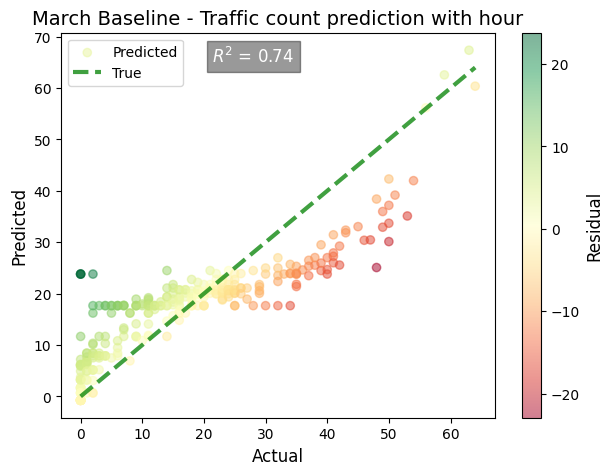

In [ ]:
%%time
result_set={}
title='{} Baseline - Traffic count prediction with hour'.format(month)
result_set['Baseline']= evaluate_model(test_prepped, target, gbtFitted, title)

#### Observation from the Baseline
1. R square = 0.74 is reasonable good with no feature engineering
2. It looks like we have more under-predications 

# 2nd Model with Hour Zone

Let's introduce the Hour Zone - Morning, Mid-Day, Evening on top of hour and trip, we check the correctness of the scaling

In [ ]:
selected_cols=['trip', 'hour' , 'HrZone']

print(training_ratio, testing_ratio)

prepped=df_training.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
prepped.show(5)

prepped=prepped.withColumn("counts", (prepped['counts']/training_ratio/num_of_days).cast('long')) 

test_prepped=df_testing.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
test_prepped.show(5)
test_prepped=test_prepped.withColumn("counts", (test_prepped['counts']/testing_ratio/num_of_days).cast('long')) 

prepped.show(5)
test_prepped.show(5)
test_prepped.printSchema()


0.7 0.30000000000000004


+-------+----+-------+------+
|   trip|hour| HrZone|counts|
+-------+----+-------+------+
|264_264|   2|Morning|   261|
|264_264|   6| MidDay|   625|
|264_264|   5|Morning|   576|
|264_264|  21|Evening|   212|
|264_264|  10| MidDay|   771|
+-------+----+-------+------+
only showing top 5 rows



+-------+----+-------+------+
|   trip|hour| HrZone|counts|
+-------+----+-------+------+
|264_264|  12| MidDay|   383|
|264_264|  16| MidDay|   320|
|264_264|   2|Morning|   132|
|264_264|  15| MidDay|   385|
|264_264|   5|Morning|   247|
+-------+----+-------+------+
only showing top 5 rows



+-------+----+-------+------+
|   trip|hour| HrZone|counts|
+-------+----+-------+------+
|264_264|   2|Morning|    12|
|264_264|   6| MidDay|    28|
|264_264|   5|Morning|    26|
|264_264|  21|Evening|     9|
|264_264|  10| MidDay|    35|
+-------+----+-------+------+
only showing top 5 rows



+-------+----+-------+------+
|   trip|hour| HrZone|counts|
+-------+----+-------+------+
|264_264|  12| MidDay|    41|
|264_264|  16| MidDay|    34|
|264_264|   2|Morning|    14|
|264_264|  15| MidDay|    41|
|264_264|   5|Morning|    26|
+-------+----+-------+------+
only showing top 5 rows

root
 |-- trip: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- HrZone: string (nullable = true)
 |-- counts: long (nullable = true)



In [ ]:
%%time
target = 'counts'
gbtFitted, i =makeGBTModel(prepped, target)

print("The Best Parameters:\n--------------------")
param_dict = gbtFitted.bestModel.stages[i].extractParamMap()

for k, v in param_dict.items():
  print('{} : {}'.format(k.name, v))

The Best Parameters:
--------------------
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
impurity : variance
labelCol : counts
leafCol : 
lossType : squared
maxBins : 32
maxDepth : 4
maxIter : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
predictionCol : prediction
seed : 8569496042429441328
stepSize : 0.1
subsamplingRate : 1.0
validationTol : 0.01
CPU times: user 3.26 s, sys: 1.6 s, total: 4.86 s
Wall time: 2min 28s


/home/t814955/geoenv2/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE:  26.60877241467769
MAE:  4.0305912699071005
RMSE Squared:  5.158369162310671
R Squared:  0.8794568101785936
Explained Variance:  169.869134260216 



CPU times: user 114 ms, sys: 17.9 ms, total: 132 ms
Wall time: 6.33 s


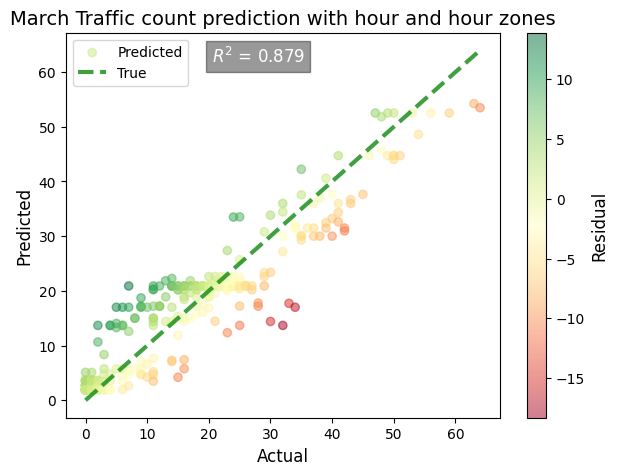

In [ ]:
%%time
title='{} Traffic count prediction with hour and hour zones'.format(month)
result_set['Baseline']= evaluate_model(test_prepped, target, gbtFitted, title)


In [ ]:
spark_model = gbtFitted.bestModel
import mlflow.spark
mlflow.spark.save_model(spark_model=spark_model, path='/tmp/best-model')


/home/t814955/geoenv2/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Observations:
1. The R square has increased by ~20% over the baseline!
2. The predicated values follows the true values much better
3. This model is usable and we loaded it for later use 

# Model with Hour Zone and cluster label 

#### Let's add  the label as part of the features to see if improvement is made - we don't have that many types of trips , this could help the model to group mthe data better

In [ ]:
selected_cols=['trip', 'hour', 'HrZone', 'cluster']

prepped=df_training.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
prepped=prepped.withColumn("counts", (prepped['counts']/training_ratio/num_of_days).cast('long')) 

test_prepped=df_testing.groupby(*selected_cols).agg(F.count('trip')).withColumnRenamed('count(trip)', 'counts').orderBy('trip', ascending=False).fillna(0)
test_prepped=test_prepped.withColumn("counts", (test_prepped['counts']/testing_ratio/num_of_days).cast('long')) 

prepped.show(5)
test_prepped.show(5)
test_prepped.printSchema()

+-------+----+-------+-------+------+
|   trip|hour| HrZone|cluster|counts|
+-------+----+-------+-------+------+
|264_264|  15| MidDay|      0|    36|
|264_264|  17| MidDay|      0|    32|
|264_264|   7| MidDay|      0|    29|
|264_264|   2|Morning|      0|    12|
|264_264|  13| MidDay|      0|    43|
+-------+----+-------+-------+------+
only showing top 5 rows



+-------+----+-------+-------+------+
|   trip|hour| HrZone|cluster|counts|
+-------+----+-------+-------+------+
|264_264|  15| MidDay|      0|    41|
|264_264|  17| MidDay|      0|    35|
|264_264|   7| MidDay|      0|    32|
|264_264|  20|Evening|      0|    16|
|264_264|  13| MidDay|      0|    45|
+-------+----+-------+-------+------+
only showing top 5 rows

root
 |-- trip: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- HrZone: string (nullable = true)
 |-- cluster: string (nullable = true)
 |-- counts: long (nullable = true)



In [ ]:
%%time
target = 'counts'
gbtFitted, i =makeGBTModel(prepped, target)

print("The Best Parameters:\n--------------------")
param_dict = gbtFitted.bestModel.stages[i].extractParamMap()

for k, v in param_dict.items():
  print('{} : {}'.format(k.name, v))

The Best Parameters:
--------------------
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
impurity : variance
labelCol : counts
leafCol : 
lossType : squared
maxBins : 32
maxDepth : 5
maxIter : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
predictionCol : prediction
seed : 8569496042429441328
stepSize : 0.1
subsamplingRate : 1.0
validationTol : 0.01
CPU times: user 3.25 s, sys: 1.58 s, total: 4.83 s
Wall time: 2min 32s


/home/t814955/geoenv2/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE:  11.597430141544097
MAE:  2.58016860306848
RMSE Squared:  3.405499984076361
R Squared:  0.9474612657357503
Explained Variance:  199.9126733213303 



CPU times: user 97.6 ms, sys: 37.9 ms, total: 136 ms
Wall time: 7.51 s


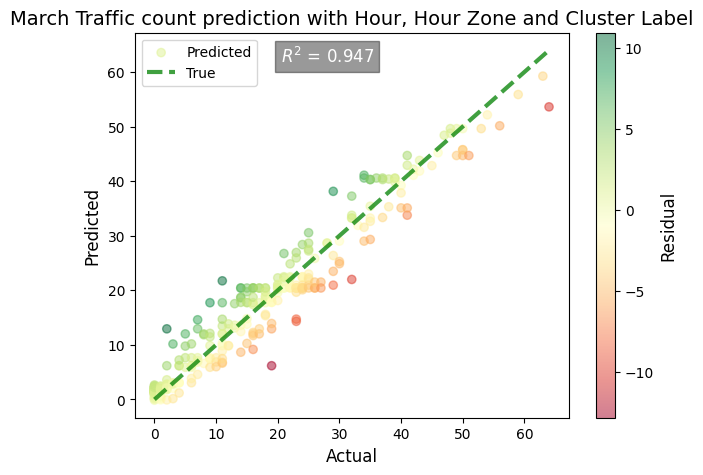

In [ ]:
%%time
title='{} Traffic count prediction with Hour, Hour Zone and Cluster Label'.format(month)
result_set['cluster']= evaluate_model(test_prepped, target, gbtFitted, title)

In [ ]:
result_set['cluster']

,counts,prediction,resd
0,43.0,41.850357,-1.1496
1,22.0,24.850357,2.8504
2,14.0,12.435642,-1.5644
3,16.0,11.705849,-4.2942
4,19.0,6.183690,-12.8163
...,...,...,...
301,4.0,7.235483,3.2355
302,6.0,5.866412,-0.1336
303,18.0,18.314856,0.3149
304,0.0,1.546175,1.5462


####Observations:

1. The R square has increased by from 4% to 6% and push the R-square to 0.9 range
2. The improvement is likely the label help to group the similar trip better together


/home/t814955/geoenv2/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE:  10.45836095420975
MAE:  2.406941311877586
RMSE Squared:  3.2339389224612374
R Squared:  0.9531465539311297
Explained Variance:  200.45347353983806 



CPU times: user 88.5 ms, sys: 19.9 ms, total: 108 ms
Wall time: 6.88 s


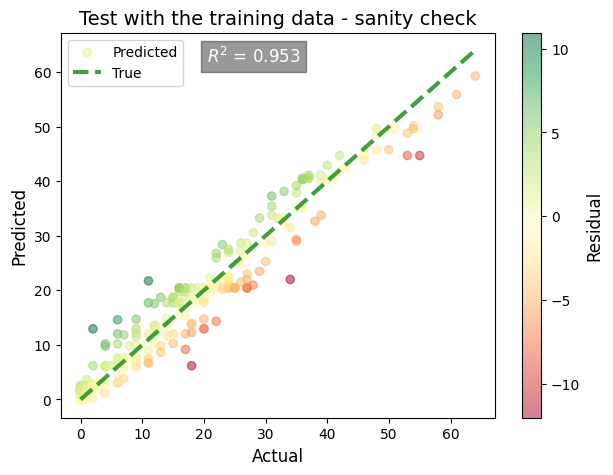

In [ ]:
%%time
title='Test with the training data - sanity check'
result_set['prepped']= evaluate_model(prepped, target, gbtFitted, title)

####


In [ ]:
spark.stop()

In [ ]:
mlflow.end_run()